In [5]:
import torch
import torch.nn as nn
import torch.optim as opt
from torchvision import datasets, transforms


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [7]:
#MNIST 데이터셋
train_dataset = datasets.MNIST(root='data',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)
test_dataset = datasets.MNIST(root='data',
                              train=False,
                              transform=transforms.ToTensor(),
                              download=True)

In [18]:
print(train_dataset)
print(test_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [9]:
# 데이터 로더
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size = 32,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=32,
                                          shuffle=False)

torch.Size([32, 1, 28, 28])
torch.Size([32])


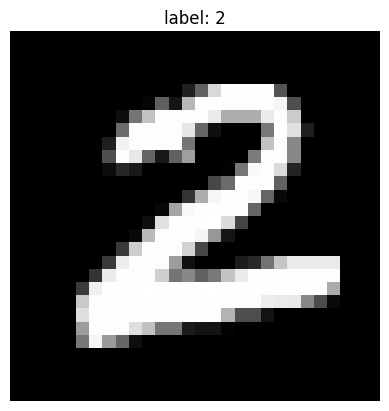

torch.Size([28, 1, 28])


In [21]:
images, labels = next(iter(train_loader))

print(images.shape) # b,c,h,w -> h,w,c [ 데이터 로더에서 가져온 1배치별 크기]
print(labels.shape)

import matplotlib.pyplot as plt
# 아 32장이 묶여잇는 하나의 배치에서 그 중 첫번재 사진을 가져오면 [1,32,32]이 되는데 저기서
# 1은 인풋 채널이라는거지? 그리고 queeze해서 1을 날린거고

img = images[0].squeeze()
label = labels[0]

plt.imshow(img,cmap='gray')
plt.title(f'label: {label.item()}') # 위에 트랜스폼에서 .ToTensor
plt.axis('off')
plt.show()

print(img.unsqueeze(1).shape)
# test_dataset = datasets.MNIST(root='data',
#                               train=False,
#                               transform=transforms.ToTensor(),
#                               download=True)
#
# 여기에선 PIL-> 텐서로 바꾸고
# test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
#                                           batch_size=32,
#                                           shuffle=False)
# 여기에서 labels를 int ->tensor스칼라로 바꿔졌다는거지? 그래서 labels.item()으로 꺼내온다든거고


In [11]:
#MLP 모델
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_cls):
        super(MLP, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()

        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()

        self.output = nn.Linear(hidden_size, num_cls)
        # softmax가 적용되지 않음. loss_fn = crossEntropy에 내장되어잇음
    def forward(self, x):
        x = self.l1(x)
        x = self.relu1(x)

        x = self.l2(x)
        x = self.relu2(x)

        out = self.output(x)

        return out

In [12]:
class CNN(nn.Module):
    def __init__(self, input_ch, hidden_size, num_cls):
        super(CNN, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(input_ch, hidden_size, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(hidden_size, hidden_size, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(hidden_size, input_ch, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.flatten = nn.Flatten()
        self.output = nn.Linear(784, num_cls)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)

        x = self.flatten(x)
        out = self.output(x)

        return out



In [23]:
input_size = 784
hidden_size = 500
num_cls = 10
epochs = 1

# model = MLP(input_size, hidden_size, num_cls).to(device)

# input_ch, hidden_size, num_cls
model = CNN(1, 16, 10).to(device) #input, output, 분류 개수(cls)

loss_fn = nn.CrossEntropyLoss() # softmax내장
optim = opt.Adam(model.parameters(), lr=0.001)

for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_loader):
        # 데이터를 디바이스로 이동
        # images = images.reshape(-1,input_size)
        images = images.to(device)
        labels = labels.to(device)

        # 모델을 실행
        outputs = model(images)#.squeeze()
        loss = loss_fn(outputs,labels)

        # 역전파 & 옵티마이저
        optim.zero_grad() # 초기화
        loss.backward() # 계산
        optim.step()# 업데이트

        if (i + 1) % 100 ==0:
            print(f"Epoch : {epoch}, loss : {loss}")

Epoch : 0, loss : 0.5667587518692017
Epoch : 0, loss : 0.8264554738998413
Epoch : 0, loss : 0.2502695322036743
Epoch : 0, loss : 0.09796273708343506
Epoch : 0, loss : 0.23633621633052826
Epoch : 0, loss : 0.35573798418045044
Epoch : 0, loss : 0.27648454904556274
Epoch : 0, loss : 0.14249888062477112
Epoch : 0, loss : 0.8019238114356995
Epoch : 0, loss : 0.2570848762989044
Epoch : 0, loss : 0.1711355596780777
Epoch : 0, loss : 0.3287279009819031
Epoch : 0, loss : 0.33588364720344543
Epoch : 0, loss : 0.225794717669487
Epoch : 0, loss : 0.12620483338832855
Epoch : 0, loss : 0.38491079211235046
Epoch : 0, loss : 0.4421403110027313
Epoch : 0, loss : 0.047638460993766785


In [14]:
print(model)

CNN(
  (block1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (block2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (block3): Sequential(
    (0): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (output): Linear(in_features=784, out_features=10, bias=True)
)


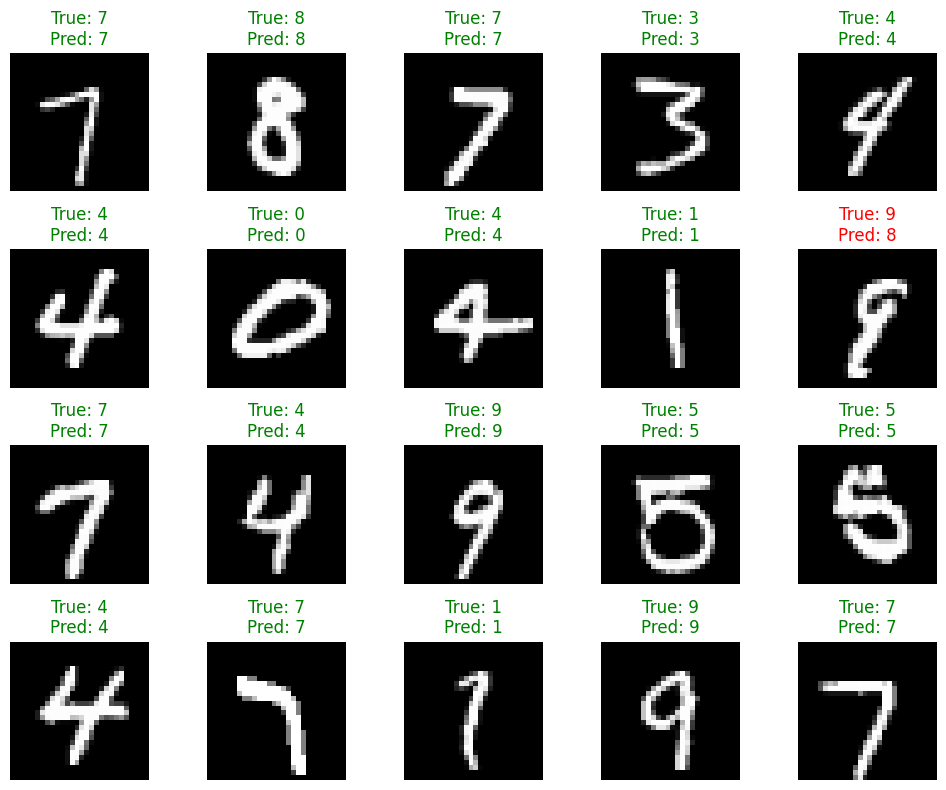

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# 테스트 셋에서 20개 샘플 추출
sample_indices = np.random.choice(len(test_dataset), 20, replace=False)
sampled_images = [test_dataset[i][0] for i in sample_indices]
sampled_labels = [test_dataset[i][1] for i in sample_indices]

# 모델 예측
model.eval()  # 평가 모드로 설정
predicted_labels = []
with torch.no_grad():
  for image in sampled_images:
    # image = image.reshape(-1, input_size).to(device)
    image = image.to(device)
    output = model(image).argmax()
    # output = [0.1, 0.05, 0.05, 0.7, 0.02, 0.01, 0.02, 0.03, 0.01, 0.01]
    # output.argmax() 👉 3 반환
    predicted_labels.append(output.item())

# 결과 시각화
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
for i, ax in enumerate(axes.flatten()):
  ax.imshow(sampled_images[i].squeeze().numpy(), cmap='gray')
  ax.set_title(f'True: {sampled_labels[i]}\nPred: {predicted_labels[i]}',
               color='green' if sampled_labels[i] == predicted_labels[i] else 'red')
  ax.axis('off')
plt.tight_layout()
plt.show()